# Окна и сглаживания

В этом ноутбуке попробуем генерить последовательность, а затем оставлять только определенные интервалы.

In [3]:
%run sunny.py

In [4]:
# imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import pandas as pd

In [5]:
import pandas as pd
# load data
tmp_data = np.array(pd.read_csv('omni2_daily_eHiYe82FKM.lst', sep='\s+'))
print(tmp_data[:10, :])
print(tmp_data.shape)

data = pd.DataFrame(tmp_data, columns=['Year', 'DOY', 'Hour', 'B', 'Kp', 'R', 'Dst', 'ap', 'F10.7', 'AE', 'AL', 'AU', 'pc', 'Lyman-alpha'])
# DOY | Dst 
data.head()
N = data['Dst'].size

[[ 1.9650e+03  2.0000e+00  0.0000e+00  9.9990e+02  2.3000e+01  3.7000e+01
   1.1000e+01  1.1000e+01  8.1500e+01  1.4700e+02  9.9999e+04  9.9999e+04
   9.9990e+02  6.2620e-03]
 [ 1.9650e+03  3.0000e+00  0.0000e+00  9.9990e+02  1.3000e+01  4.4000e+01
   4.0000e+00  7.0000e+00  7.9400e+01  6.9000e+01  9.9999e+04  9.9999e+04
   9.9990e+02  6.2620e-03]
 [ 1.9650e+03  4.0000e+00  0.0000e+00  9.9990e+02  1.0000e+01  4.4000e+01
   1.2000e+01  4.0000e+00  7.8000e+01  8.6000e+01  9.9999e+04  9.9999e+04
   9.9990e+02  6.2270e-03]
 [ 1.9650e+03  5.0000e+00  0.0000e+00  9.9990e+02  7.0000e+00  3.7000e+01
   7.0000e+00  2.0000e+00  7.7400e+01  4.4000e+01  9.9999e+04  9.9999e+04
   9.9990e+02  6.2620e-03]
 [ 1.9650e+03  6.0000e+00  0.0000e+00  9.9990e+02  3.0000e+00  2.8000e+01
   1.1000e+01  2.0000e+00  7.7700e+01  3.3000e+01  9.9999e+04  9.9999e+04
   9.9990e+02  6.2620e-03]
 [ 1.9650e+03  7.0000e+00  0.0000e+00  9.9990e+02  1.3000e+01  2.6000e+01
   1.3000e+01  4.0000e+00  7.5700e+01  5.5000e+01  

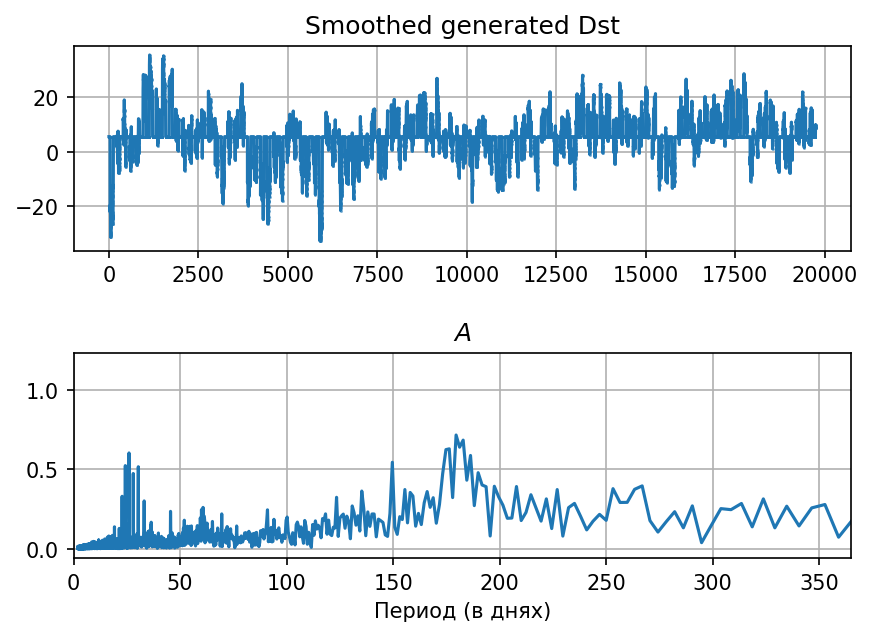

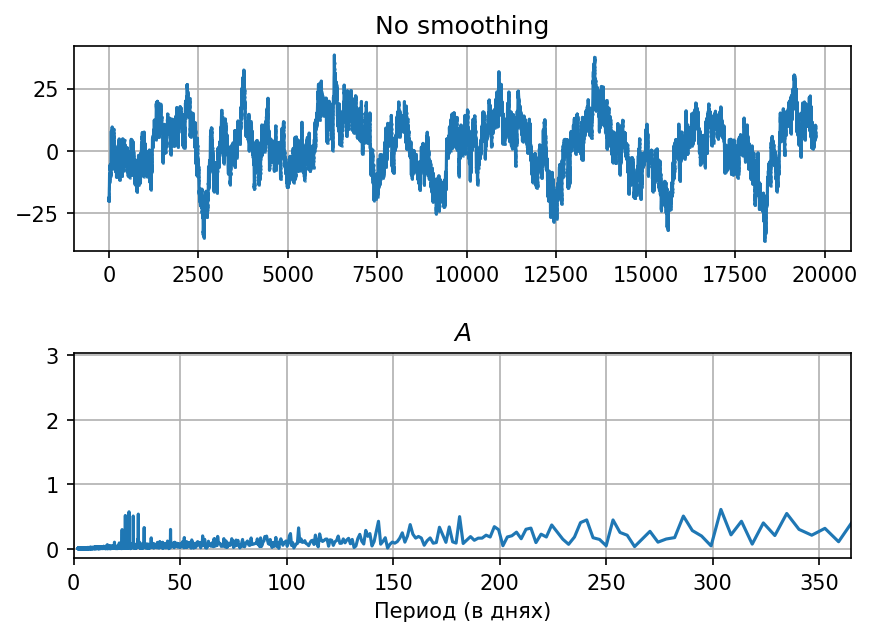

In [6]:
def action1():
    arr = imitate_Dst(p=0.995, to_smooth=True)
    mFFT(arr, draw=True, x2=365, name="Smoothed generated Dst")
    arr2 = imitate_Dst(p=0.995, to_smooth=False)
    mFFT(arr2, draw=True, x2=365, name="No smoothing")
action1()

Будем извлекать среднее значение амплитуд в $\varepsilon$-окрестности 27 дней и 183 дней. Судя по графикам для 27 дней следует взять $\varepsilon = 4$ (в днях). В следующей клетке - график для наглядности главного интервала частот.

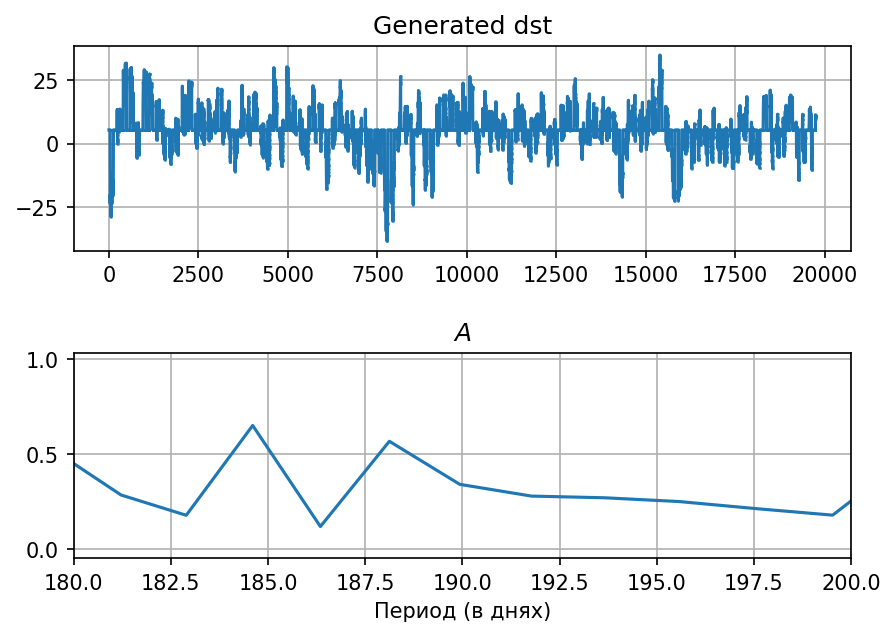

In [7]:
def action3():
    arr = imitate_Dst(p=0.995, to_smooth=True, B_2=0)
    mFFT(arr, draw=True, x1=180, x2=200, name="Generated dst")
action3()

In [8]:
def smooth_amps(t_from, t_to, amps):
    arr = zip(amps[0], amps[1])
    diap = list(filter(lambda x: t_from <= x[0] <= t_to, arr))
    ln = len(diap)
    return sum(map(lambda x : x[1], diap)) / ln

def smooth_27(amps):
    return smooth_amps(27 - 4, 27 + 4, amps)

def smooth_183(amps):
    return smooth_amps(183 - 4, 183 + 4, amps)

def smoothed_relation(amps):
    return smooth_27(amps) / max(0.1, smooth_183(amps))

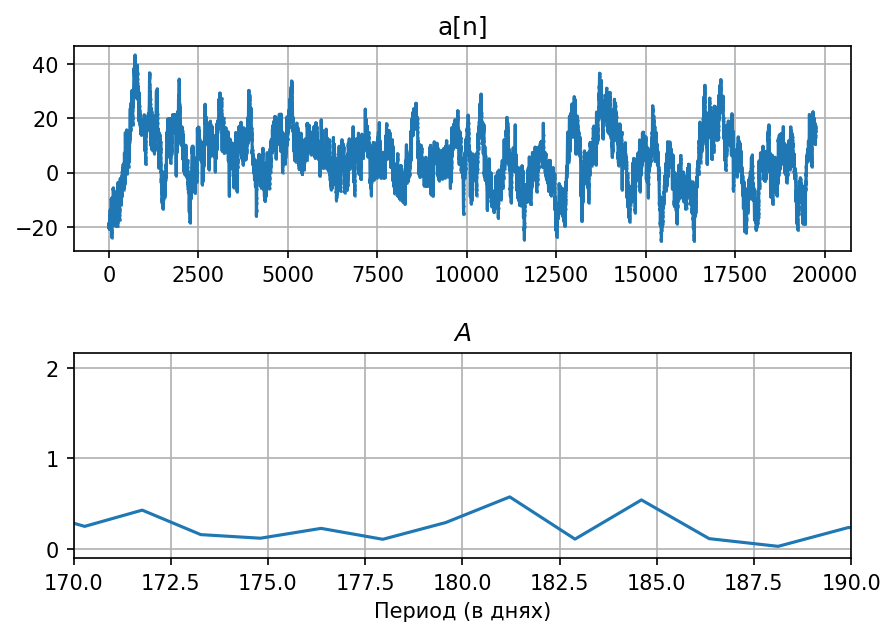

smoothed 27 :  0.05276024734625138
smoothed 183:  0.32474606051087174
relation    :  0.16246616591207297


In [9]:
def action4():
    seq = imitate_Dst(p=0.995)
    res = list(mFFT(seq, draw=True, x1=170, x2=190))
    print("smoothed 27 : ", smooth_27(res))
    print("smoothed 183: ", smooth_183(res))
    print("relation    : ", smoothed_relation(res))
action4()

Ниже -- вычисление отношения амплитуд без сглаживания исходного графика

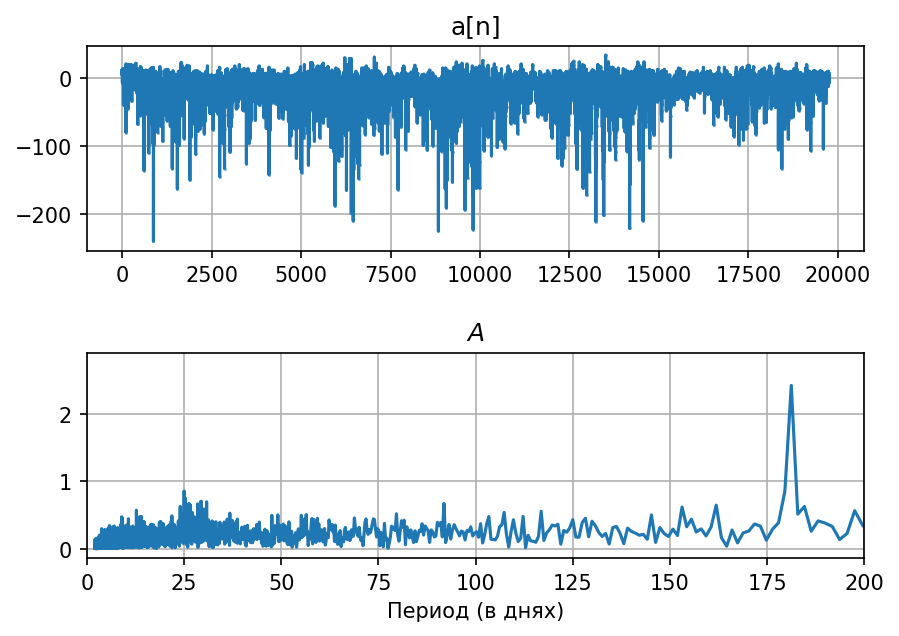

smoothed 27 :  0.27091563376720407
smoothed 183:  0.9363387485928024
relation    :  0.28933506615458954


In [10]:
def action5():
    amps = list(mFFT(data['Dst'], draw=True, x1 = 0, x2 = 200))
    print("smoothed 27 : ", smooth_27(amps))
    print("smoothed 183: ", smooth_183(amps))
    print("relation    : ", smoothed_relation(amps))
action5()

Ниже -- то же самое вычисление, но исходный массив сглаживается вне равноденствий

График ниже получен следующим способом: брались сгенерированные без сглаживания последовательности для разных значений, после чего брались средние значения амплитуд на отрезках $[27-4, 27+4]$ и $[183-4, 183+4]$ спектра. После чего бралось отношение значения для 27 дней к значению 183 дней. 

KeyboardInterrupt: 

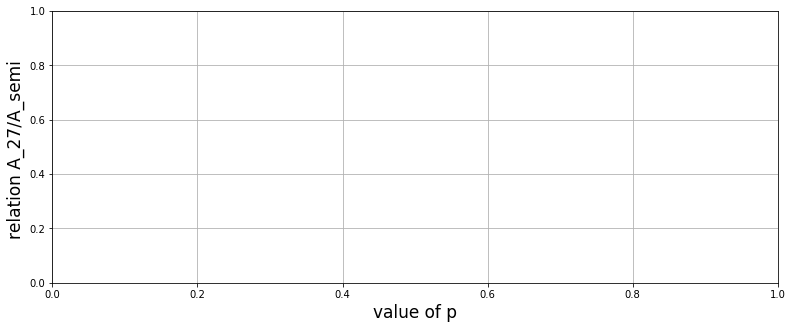

In [11]:
#draw_amplitude_relation(n=200)

Различие между графиком сверху и графиком снизу заключается в том, что во втором случае добавлено сглаживание в генерацию.

In [ ]:
#draw_amplitude_relation(n=200, to_smooth=True)

$x_t = px_{t-1} + \xi_t$

$\xi_t \sim N(sin(wt), D)$
---------------------------------

$x_t = px_{t-1} + \eta_t$

$\eta_t \sim N(0, D)$

$w = 2\pi / 27$

In [ ]:
#draw_amplitude_relation(n=200, to_smooth=True)

## Подгон

Из данных знаем три параметра модели из пяти:
* $a \approx 19$ -- амплитуда синуса (??) 
* $D_2 \approx  19.1047597$ -- дисперсия обычного шума  $\eta$
* $b_2 \approx -12.2625514$ -- среднее обычного шума $\eta$
Предположение: возьмем данные по всем весенне-осенним пикам, для каждого года вычтем среднее значение на всем остальном промежутке. После этого возьмем среднее значение от максимумов. По идее должен выделиться максимум синуса, умноженного на амплитуду.

In [12]:
mx1 = 0
mx2 = 0

for i in range(55):
    dst1 = data.copy()
    dst2 = data.copy()
    mx1 += get_year_max(dst1, 79, 30, i)
    mx2 += get_year_max(dst2, 266, 30, i)
mx = (mx1 + mx2) / 110
print(mx, mx2, mx1)
mean_val = data["Dst"].mean()
print("mean = ", mean_val)
sin_amp = mx - mean_val
print("sinus amplitude =", sin_amp)

6.972727272727273 361.0 406.0
mean =  -14.83834548400162
sinus amplitude = 21.81107275672889


решим пока, что амплитуда синуса равна где-то $20$. Продублируем формулы с конкретными параметрами:
\begin{align}
& x_t = px_{t-1} + \xi_t, \quad t \in \left[79 - 30, 79 + 30\right] \cup [266 - 30, 266 + 30]\\
& x_t = px_{t - 1} + \eta_t, \ \ otherwise \\
& \xi_t \sim \mathcal{N}(20\sin (\omega t), D_1^2) , \quad \omega = \dfrac{2\pi}{27}\\
& \eta_t \sim \mathcal{N}(-12.2626, (19.1048)^2)\\
\end{align}

Перебор значений. Будем перебирать значения $p$ и $D_1$, для каждой комбинации генерировать последовательность. Затем находим параметры $b_2$ и $D_2$ (среднее значение и стандартное отклонение для обычного шума). Выбираем несколько лучших по сумме квадратов отклонений, строим их графики, смотрим глазами, что больше похоже на правду.

In [13]:
def get_ad_normal_noise(arr):
    dst1 = filt_simple(arr, 174, 45)
    dst2 = filt_simple(arr, 357, 45)
    a1 = dst1.mean()
    a2 = dst2.mean()
    d1 = dst1.std()
    d2 = dst2.std()
    return ((a1 + a2)/2, ((d1**2 + d2**2)**0.5) / 2)

def get_error(arr1, arr2):
    (a1, d1) = get_ad_normal_noise(arr1)
    (a2, d2) = get_ad_normal_noise(arr2)
    return (a1 - a2)**2 + (d1 - d2)**2

In [14]:
def get_errors(b_2=-12.2626,  d_2=19.1048, a_sin=20, delta=30):
    from sklearn.metrics import mean_squared_error
    ps = np.linspace(0.3, 1, 40) # p
    ds = np.linspace(0, 30, 10) # стандатное отклонение синуса
    results = []
    for p in ps:
        for d_1 in ds:
            gen_data = imitate_Dst(delta=delta, T=27, p=p, A_sin=a_sin, to_smooth=True, D_1=d_1, B_2=b_2, D_2=d_2)
            error = get_error(gen_data[1:], data['Dst'])
            results.append((p, d_1, error))
    return results

In [15]:
def get_top_errors(b_2=-12.2626,  d_2=19.1048, a_sin=20, delta=30):
    results = get_errors(b_2, d_2, a_sin, delta)
    top_results = sorted(results, key=lambda x: x[2])
    df_errors = pd.DataFrame(top_results, columns=["p", "D1", "error"])
    sorted_errors = df_errors.sort_values(by='error')
    sorted_errors.head
    return sorted_errors

In [16]:
#top = get_top_errors()
#top

## Графики для лучших значений

In [17]:
# b_2 = -12.2626
# d_2 = 19.1048
# a_sin = 20
# delta = 30
# arr_top = top.head(10).values
# Dst_generated = []
# for x in arr_top:
#     Dst_generated.append(imitate_Dst(delta=delta, T=27, p=x[0], to_smooth=True, D_1=x[1], B_2=b_2, D_2=d_2, A_sin=a_sin))
#     name = "p="+str(x[0])+" D_1="+str(x[1])
#     mFFT(arr=Dst_generated[-1], draw=True, x2=365, name=name)

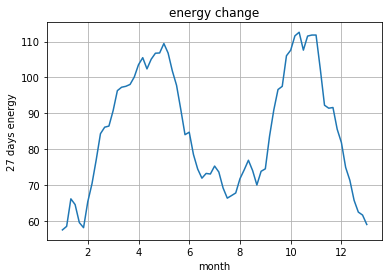

In [18]:
target = retrieve_energy(data, draw=True)

def get_error_sin(arr):
    df = pd.DataFrame(arr, columns=['Dst'])
    df['DOY'] = np.arange(0, len(arr))
    current = retrieve_energy(df, draw=False)
    return (target[0] - current[0])**2 + (target[2] - current[1])**2 + (target[2] - current[2])**2

def get_errors_sin(b_2=-12.2626,  d_2=19.1048, a_sin=20, delta=30):
    from sklearn.metrics import mean_squared_error
    ps = np.linspace(0.3, 1, 50) # p
    ds = np.linspace(0, 30, 20) # стандатное отклонение синуса
    results = []
    # def imitate_Dst(delta=45, T=27, p=1, A_sin=1, to_smooth=False, D_1=1, B_2=1, D_2=1):
    for p in ps:
        for d_1 in ds:
            gen_data = imitate_Dst(delta=delta, T=27, p=p, A_sin=a_sin, to_smooth=True, D_1=d_1, B_2=b_2, D_2=d_2, only_sin=True)
            error = get_error_sin(gen_data[1:])
            results.append((p, d_1, error))
    return results

def get_top_errors_sin(b_2=-12.2626,  d_2=19.1048, a_sin=20, delta=30):
    results = get_errors_sin(b_2, d_2, a_sin, delta)
    top_results = sorted(results, key=lambda x: x[2])
    df_errors = pd.DataFrame(top_results, columns=["p", "D1", "error"])
    sorted_errors = df_errors.sort_values(by='error')
    sorted_errors.head
    return sorted_errors


In [19]:
#top_sin = get_top_errors_sin()
#top_sin

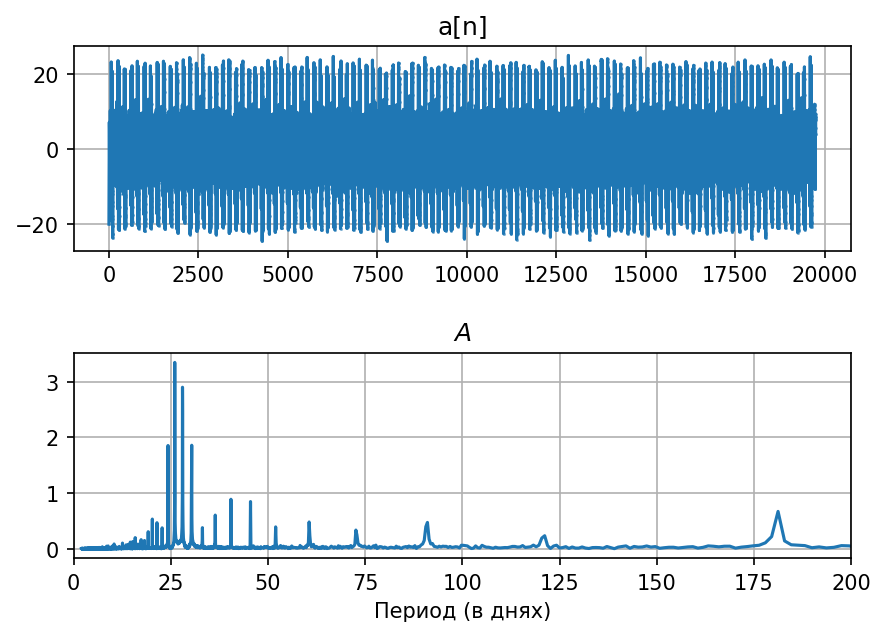

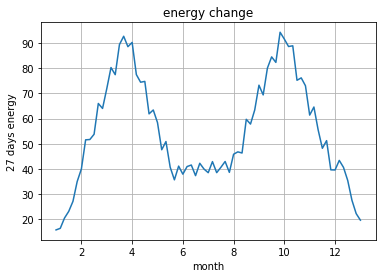

In [45]:
def get_and_draw_energy_from_params(d_1, a_sin, b_2, d_2, a_sin2, delta, p):
    gend = imitate_Dst(delta=delta, T=27, p=p, A_sin=a_sin, A_sin2=a_sin2, to_smooth=False, D_1=d_1, B_2=b_2, D_2=d_2, only_sin=True)
    mFFT(gend, draw=True, x1=0, x2=200)
    arrx = pd.DataFrame(gend, columns=['Dst'])
    arrx['DOY'] = np.arange(0, len(arrx['Dst']))
    retrieve_energy(arrx, draw=True)
    
get_and_draw_energy_from_params(d_1 = 2 * 0.3, a_sin = 18.5 * 0.3, b_2 = -12.2626 * 0.3, d_2 = 2 * 0.3, a_sin2 = 8 * 0.3, delta = 29, p=0.85)

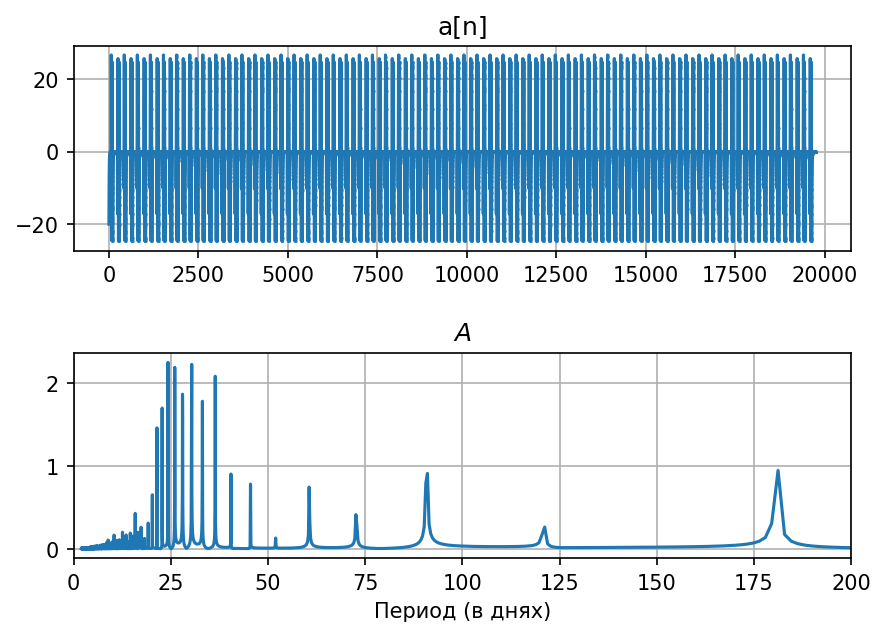

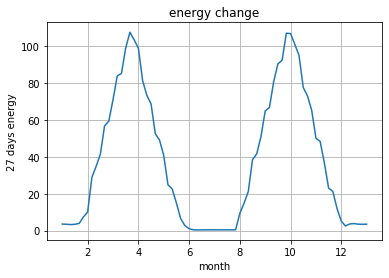

In [54]:
    
get_and_draw_energy_from_params(d_1 = 0, a_sin = 18.5 * 0.35, b_2 = 0, d_2 = 0, a_sin2= 0, delta = 30, p=0.85)
#get_and_draw_energy_from_params(d_1 = 0, a_sin = 18.5, b_2 = 0"""-12.2626""", d_2 = """4"""0, a_sin2= """8"""0, delta = 30, p=0.85)

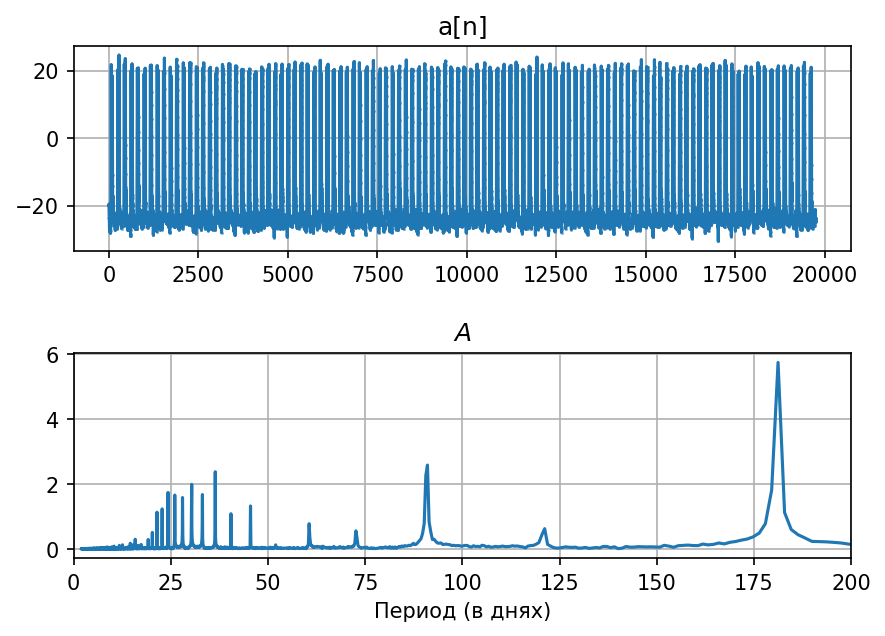

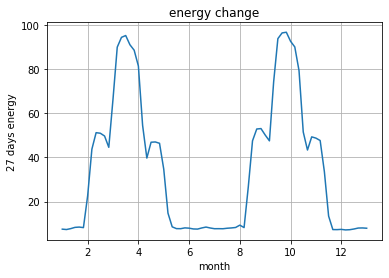

(95.31962336836186, 7.491497763249737, 96.80948762562832)

In [22]:
b_2 = -12.2626 * 0.3
d_2 = 2 * 0.3 # 4
a_sin = 18.5 * 0.3
a_sin2 = 8 * 0.3
delta = 30
d_1 = 2 * 0.3# 0.06
gend = imitate_Dst(delta=delta, T=27, p=0.85, A_sin=a_sin, A_sin2=a_sin2, to_smooth=False, D_1=d_1, B_2=b_2, D_2=d_2, only_sin=False)
mFFT(gend, draw=True, x1=0, x2=200)
arrx = pd.DataFrame(gend, columns=['Dst'])
arrx['DOY'] = np.arange(0, len(arrx['Dst']))
retrieve_energy(arrx, draw=True)